In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1) 데이터 준비와 확인

In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [3]:
# 데이터 로드하기
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7ff8feb1c490>)

In [4]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [5]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2) 데이터로더 구성

- 데이터의 중복 제거

In [6]:
# 데이터 정제하기
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [7]:
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

In [8]:
print(train_data.isnull().values.any())

True


In [9]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [10]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


- NaN 결측치 제거

In [11]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [12]:
len(train_data)

146182

In [13]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [14]:
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    391
label         0
dtype: int64


In [15]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
584,7117896,NaN,0
593,6478189,NaN,0
638,9364602,NaN,0
668,1600635,NaN,0
1559,6918082,NaN,1


In [16]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145791


In [17]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48995


- 한국어 토크나이저로 토큰화
- 불용어 (Stopwords) 제거
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [18]:
from collections import Counter
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [19]:
train_data['document']

0                                         아 더빙 진짜 짜증나네요 목소리
1                                흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                                 교도소 이야기구먼 솔직히 재미는 없다평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...
                                ...                        
149994                  디케이드 다음에 더블 다음에 오즈인데 더블은 조금밖에 안나오네요
149995                                      인간이 문제지 소는 뭔죄인가
149997                        이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다
149998                           청춘 영화의 최고봉방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 143681, dtype: object

In [20]:
X_train

[[27, 67, 891, 33, 214, 15, 28, 698],
 [994, 480, 491, 636, 4, 110, 1553, 47, 866, 947, 11, 38, 364],
 [19, 192, 2],
 [8032, 143, 4131, 278, 86, 13, 5, 51, 3326],
 [2,
  8488,
  1049,
  47,
  2698,
  54,
  4,
  2620,
  34,
  1116,
  29,
  323,
  36,
  17,
  35,
  54,
  2,
  2,
  393,
  2875,
  1674,
  5],
 [625, 2, 2, 425, 171, 1462, 660, 1590, 669, 46, 2, 4, 60, 2166, 118, 721],
 [237, 350, 8, 354, 1918, 50, 11, 779, 5],
 [233,
  1357,
  133,
  5,
  391,
  707,
  2,
  2,
  47,
  1432,
  269,
  92,
  232,
  23,
  886,
  24,
  321,
  608,
  500,
  475,
  546,
  5,
  3165,
  8489,
  17,
  1382,
  1382,
  66,
  282,
  13,
  5,
  47,
  95,
  7,
  69,
  17,
  2,
  37],
 [116, 13, 18, 86, 12, 269, 22, 43, 4],
 [57,
  612,
  51,
  225,
  705,
  532,
  81,
  17,
  477,
  1402,
  596,
  688,
  74,
  17,
  19,
  2,
  12,
  15],
 [2],
 [81,
  71,
  405,
  2342,
  99,
  200,
  58,
  5,
  92,
  175,
  2514,
  844,
  2,
  642,
  2621,
  2134,
  6674,
  5],
 [264, 102, 2, 6, 2, 8033, 2, 71, 2, 403, 3

- 사전 word_to_index 구성

In [21]:
word_to_index

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '<UNUSED>': 3,
 '영화': 4,
 '다': 5,
 '고': 6,
 '하': 7,
 '을': 8,
 '보': 9,
 '게': 10,
 '지': 11,
 '있': 12,
 '없': 13,
 '좋': 14,
 '나': 15,
 '었': 16,
 '만': 17,
 '는데': 18,
 '너무': 19,
 '봤': 20,
 '적': 21,
 '안': 22,
 '정말': 23,
 '로': 24,
 '것': 25,
 '음': 26,
 '아': 27,
 '네요': 28,
 '어': 29,
 '지만': 30,
 '재밌': 31,
 '같': 32,
 '진짜': 33,
 '에서': 34,
 '했': 35,
 '기': 36,
 '네': 37,
 '않': 38,
 '거': 39,
 '점': 40,
 '았': 41,
 '수': 42,
 '되': 43,
 '면': 44,
 'ㅋㅋ': 45,
 '인': 46,
 '연기': 47,
 '말': 48,
 '주': 49,
 '내': 50,
 '평점': 51,
 '최고': 52,
 '이런': 53,
 '던': 54,
 '어요': 55,
 '할': 56,
 '왜': 57,
 '겠': 58,
 '스토리': 59,
 'ㅋㅋㅋ': 60,
 '해': 61,
 '습니다': 62,
 '듯': 63,
 '아니': 64,
 '생각': 65,
 '드라마': 66,
 '더': 67,
 '그': 68,
 '사람': 69,
 '싶': 70,
 '때': 71,
 '감동': 72,
 '배우': 73,
 '함': 74,
 '본': 75,
 '까지': 76,
 '알': 77,
 '만들': 78,
 '뭐': 79,
 '내용': 80,
 '볼': 81,
 '보다': 82,
 '감독': 83,
 '라': 84,
 '그냥': 85,
 '재미': 86,
 '시간': 87,
 '지루': 88,
 '중': 89,
 '재미있': 90,
 '였': 91,
 '년': 92,
 '잼': 93,
 '사랑': 94,
 

In [22]:
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word

{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '<UNUSED>',
 4: '영화',
 5: '다',
 6: '고',
 7: '하',
 8: '을',
 9: '보',
 10: '게',
 11: '지',
 12: '있',
 13: '없',
 14: '좋',
 15: '나',
 16: '었',
 17: '만',
 18: '는데',
 19: '너무',
 20: '봤',
 21: '적',
 22: '안',
 23: '정말',
 24: '로',
 25: '것',
 26: '음',
 27: '아',
 28: '네요',
 29: '어',
 30: '지만',
 31: '재밌',
 32: '같',
 33: '진짜',
 34: '에서',
 35: '했',
 36: '기',
 37: '네',
 38: '않',
 39: '거',
 40: '점',
 41: '았',
 42: '수',
 43: '되',
 44: '면',
 45: 'ㅋㅋ',
 46: '인',
 47: '연기',
 48: '말',
 49: '주',
 50: '내',
 51: '평점',
 52: '최고',
 53: '이런',
 54: '던',
 55: '어요',
 56: '할',
 57: '왜',
 58: '겠',
 59: '스토리',
 60: 'ㅋㅋㅋ',
 61: '해',
 62: '습니다',
 63: '듯',
 64: '아니',
 65: '생각',
 66: '드라마',
 67: '더',
 68: '그',
 69: '사람',
 70: '싶',
 71: '때',
 72: '감동',
 73: '배우',
 74: '함',
 75: '본',
 76: '까지',
 77: '알',
 78: '만들',
 79: '뭐',
 80: '내용',
 81: '볼',
 82: '보다',
 83: '감독',
 84: '라',
 85: '그냥',
 86: '재미',
 87: '시간',
 88: '지루',
 89: '중',
 90: '재미있',
 91: '였',
 92: '년',
 93: '잼',
 94: '사랑',
 

In [23]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [24]:
print(get_decoded_sentence(X_train[0], index_to_word))

더 빙 진짜 짜증 나 네요 목소리


# 3) 모델구성을 위한 데이터 분석 및 가공

리뷰의 최대 길이 : 83
리뷰의 평균 길이 : 13.934681690689793


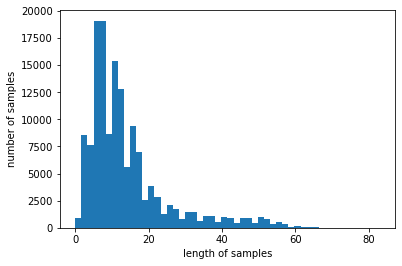

In [25]:
# 패딩
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [26]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [27]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 90.57425825265693


In [28]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [29]:
X_train

array([[   0,    0,    0, ...,   15,   28,  698],
       [   0,    0,    0, ...,   11,   38,  364],
       [   0,    0,    0, ...,   19,  192,    2],
       ...,
       [   0,    0,    0, ...,    2, 2650,    5],
       [   0,    0,    0, ...,   54,  368, 8187],
       [   0,    0,    0, ...,   80, 2608,    4]], dtype=int32)

In [30]:
X_test

array([[   0,    0,    0, ...,    0,  802,  128],
       [   0,    0,    0, ..., 3398,   64,  862],
       [   0,    0,    0, ...,    6,    9,   36],
       ...,
       [   0,    0,    0, ...,    7,   10, 1395],
       [   0,    0,    0, ...,   61,  300,   37],
       [   0,    0,    0, ...,  163,   57,  988]], dtype=int32)

# 4) 모델구성 및 validation set 구성
    
# 5) 모델 훈련 개시
    
# 6) Loss, Accuracy 그래프 시각화

In [49]:
## 1D Convolution Neural Network(1D-CNN)

In [90]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 1   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(32, 5, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 5, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 1)           10000     
_________________________________________________________________
conv1d_19 (Conv1D)           (None, None, 32)          192       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, None, 16)          2576      
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 16)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_24 (Dense)             (None, 1)               

In [91]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('conv1d', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [92]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1911/1916 [============================>.] - ETA: 0s - loss: 0.5404 - acc: 0.7283
Epoch 00001: val_acc improved from -inf to 0.76988, saving model to conv1d
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: conv1d/assets
1916/1916 [==============================] - 6s 3ms/step - loss: 0.5404 - acc: 0.7283 - val_loss: 0.4867 - val_acc: 0.7699
Epoch 2/15
1900/1916 [============================>.] - ETA: 0s - loss: 0.4763 - acc: 0.7780
Epoch 00002: val_acc improved from 0.76988 to 0.77882, saving model to conv1d
INFO:tensorflow:Assets written to: conv1d/assets
1916/1916 [==============================] - 6s 3ms/step - loss: 0.4764 - acc: 0.7779 - val_loss: 0.4741 - val_acc: 0.7788
Epoch 3/15
1914/1916 [============================>.] - ETA: 0s - loss: 0.4625 - acc: 0.7877
Epoch 00003: val_acc improved from 0.77882 to 0.78223, saving model to conv1d
INFO:tensorflow:Assets written to: conv1d/assets
1916/1916 [=====

In [93]:
loaded_model = load_model('conv1d')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1514/1514 [==============================] - 5s 3ms/step - loss: 0.4338 - acc: 0.8021

 테스트 정확도: 0.8021


In [94]:
## LSTM으로 네이버 영화 리뷰 감성 분류하기
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

vocab_size = 10000
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))


In [95]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('lstm_model', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [96]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1909/1916 [============================>.] - ETA: 0s - loss: 0.3909 - acc: 0.8214
Epoch 00001: val_acc improved from -inf to 0.84014, saving model to lstm_model
INFO:tensorflow:Assets written to: lstm_model/assets
1916/1916 [==============================] - 18s 9ms/step - loss: 0.3908 - acc: 0.8215 - val_loss: 0.3549 - val_acc: 0.8401
Epoch 2/15
1912/1916 [============================>.] - ETA: 0s - loss: 0.3273 - acc: 0.8575
Epoch 00002: val_acc improved from 0.84014 to 0.85510, saving model to lstm_model
INFO:tensorflow:Assets written to: lstm_model/assets
1916/1916 [==============================] - 15s 8ms/step - loss: 0.3274 - acc: 0.8574 - val_loss: 0.3302 - val_acc: 0.8551
Epoch 3/15
1909/1916 [============================>.] - ETA: 0s - loss: 0.3026 - acc: 0.8711
Epoch 00003: val_acc improved from 0.85510 to 0.86056, saving model to lstm_model
INFO:tensorflow:Assets written to: lstm_model/assets
1916/1916 [==============================] - 16s 9ms/step - loss: 0.302

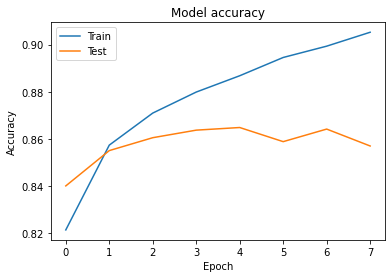

In [97]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

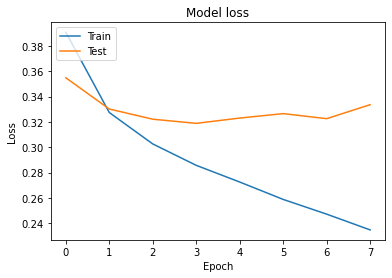

In [98]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [99]:
loaded_model = load_model('lstm_model')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1514/1514 [==============================] - 3s 2ms/step - loss: 0.3288 - acc: 0.8621

 테스트 정확도: 0.8621


In [100]:
## Multi-Kernel 1D CNN으로 네이버 영화 리뷰 감성 분류하기

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

embedding_dim = 128
dropout_prob = (0.5, 0.8)
num_filters = 128

model_input = Input(shape = (max_len,))
z = Embedding(10000, embedding_dim, input_length = max_len, name="embedding")(model_input)
z = Dropout(dropout_prob[0])(z)

conv_blocks = []

for sz in [3, 4, 5]:
    conv = Conv1D(filters = num_filters,
                         kernel_size = sz,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)
    
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_prob[1])(z)
z = Dense(128, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)

model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])


In [101]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('CNN_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size = 64, epochs=10, validation_data = (X_test, y_test), verbose=2, callbacks=[es, mc])

Epoch 1/10

Epoch 00001: val_acc improved from -inf to 0.84425, saving model to CNN_model.h5
2246/2246 - 25s - loss: 0.4283 - acc: 0.7952 - val_loss: 0.3610 - val_acc: 0.8442
Epoch 2/10

Epoch 00002: val_acc improved from 0.84425 to 0.84811, saving model to CNN_model.h5
2246/2246 - 26s - loss: 0.3512 - acc: 0.8479 - val_loss: 0.3522 - val_acc: 0.8481
Epoch 3/10

Epoch 00003: val_acc improved from 0.84811 to 0.85018, saving model to CNN_model.h5
2246/2246 - 27s - loss: 0.3274 - acc: 0.8593 - val_loss: 0.3481 - val_acc: 0.8502
Epoch 4/10

Epoch 00004: val_acc improved from 0.85018 to 0.85117, saving model to CNN_model.h5
2246/2246 - 25s - loss: 0.3103 - acc: 0.8680 - val_loss: 0.3452 - val_acc: 0.8512
Epoch 5/10

Epoch 00005: val_acc did not improve from 0.85117
2246/2246 - 26s - loss: 0.2963 - acc: 0.8748 - val_loss: 0.3470 - val_acc: 0.8502
Epoch 6/10

Epoch 00006: val_acc did not improve from 0.85117
2246/2246 - 25s - loss: 0.2837 - acc: 0.8798 - val_loss: 0.3484 - val_acc: 0.8507
Epo

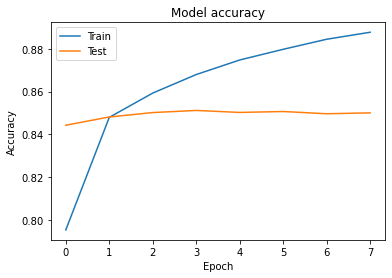

In [102]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

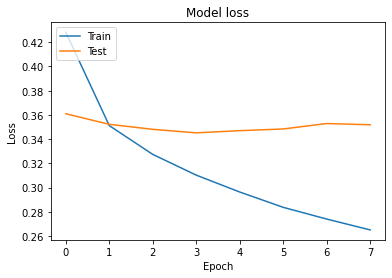

In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [104]:
loaded_model = load_model('CNN_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1514/1514 [==============================] - 2s 2ms/step - loss: 0.3452 - acc: 0.8512

 테스트 정확도: 0.8512


In [105]:
## GRU로 네이버 영화 리뷰 감성 분류하기
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Embedding(10000, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('gru_model', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [106]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1913/1916 [============================>.] - ETA: 0s - loss: 0.3859 - acc: 0.8229
Epoch 00001: val_acc improved from -inf to 0.84692, saving model to gru_model
INFO:tensorflow:Assets written to: gru_model/assets
1916/1916 [==============================] - 18s 10ms/step - loss: 0.3859 - acc: 0.8230 - val_loss: 0.3470 - val_acc: 0.8469
Epoch 2/15
1913/1916 [============================>.] - ETA: 0s - loss: 0.3244 - acc: 0.8595
Epoch 00002: val_acc improved from 0.84692 to 0.85607, saving model to gru_model
INFO:tensorflow:Assets written to: gru_model/assets
1916/1916 [==============================] - 17s 9ms/step - loss: 0.3243 - acc: 0.8596 - val_loss: 0.3317 - val_acc: 0.8561
Epoch 3/15
1907/1916 [============================>.] - ETA: 0s - loss: 0.3000 - acc: 0.8718
Epoch 00003: val_acc improved from 0.85607 to 0.86140, saving model to gru_model
INFO:tensorflow:Assets written to: gru_model/assets
1916/1916 [==============================] - 17s 9ms/step - loss: 0.3002 - a

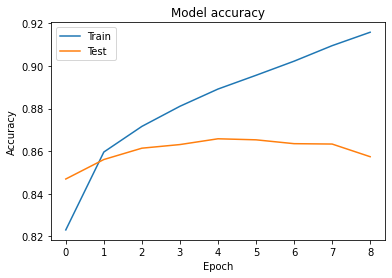

In [107]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

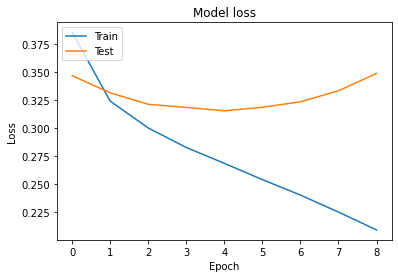

In [108]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [109]:
loaded_model = load_model('gru_model')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1514/1514 [==============================] - 3s 2ms/step - loss: 0.3197 - acc: 0.8620

 테스트 정확도: 0.8620


# 7) 학습된 Embedding 레이어 분석

In [66]:
## 네이버 영화리뷰 데이터를 통해 Word2Vec 생성 (자체학습한 임베딩)
import csv
from konlpy.tag import Okt
from gensim.models import word2vec

#네이버 영화 코퍼스를 읽는다.
f = open('ratings_train.txt', 'r', encoding='utf-8')
rdr = csv.reader(f, delimiter='\t')
rdw = list(rdr)
f.close()

#트위터 형태소 분석기를 로드한다. Twiter가 KoNLPy v0.4.5 부터 Okt로 변경 되었다.
twitter = Okt()

#텍스트를 한줄씩 처리합니다.
result = []
for line in rdw:
    #형태소 분석하기, 단어 기본형 사용
    malist = twitter.pos( line[1], norm=True, stem=True)
    r = []
    for word in malist:
        #Josa”, “Eomi”, “'Punctuation” 는 제외하고 처리
        if not word[1] in ["Josa","Eomi","Punctuation"]:
            r.append(word[0])
    #형태소 사이에 공백 " "  을 넣습니다. 그리고 양쪽 공백을 지웁니다.
    rl = (" ".join(r)).strip()
    result.append(rl)
    #print(rl)

#형태소들을 별도의 파일로 저장 합니다.
with open("NaverMovie.nlp",'w', encoding='utf-8') as fp:
    fp.write("\n".join(result))


#Word2Vec 모델 만들기
wData = word2vec.LineSentence("NaverMovie.nlp")
wModel =word2vec.Word2Vec(wData, size=200, window=10, hs=1, min_count=2, sg=1)
wModel.save("NaverMovie.model")
print("Word2Vec Modeling finished")

Word2Vec Modeling finished


In [67]:
import pprint
model = word2vec.Word2Vec.load("NaverMovie.model")

pprint.pprint(model.wv.most_similar(positive=["사랑"]))
pprint.pprint(model.wv.most_similar(positive=["재미"]))
pprint.pprint(model.wv.most_similar(positive=["최고"]))

[('결별', 0.6651413440704346),
 ('기적처럼', 0.6647357940673828),
 ('맺힌다', 0.6607751846313477),
 ('모진', 0.6432325839996338),
 ('벤다', 0.6417429447174072),
 ('경아', 0.6414312720298767),
 ('삶속', 0.6409377455711365),
 ('서머', 0.6350699067115784),
 ('아가페', 0.63065505027771),
 ('사람과', 0.6294083595275879)]
[('없슴', 0.6181846857070923),
 ('칙스', 0.5769656300544739),
 ('ㅠㅡㅜ', 0.5743016600608826),
 ('무것', 0.5723000764846802),
 ('콩트', 0.5684665441513062),
 ('나용', 0.566312849521637),
 ('재미없다', 0.5639356970787048),
 ('지렁이', 0.5632568597793579),
 ('번봣어', 0.5603448152542114),
 ('애매', 0.5600825548171997)]
[('꼽을', 0.7124364972114563),
 ('최고다', 0.6748347282409668),
 ('꼽는', 0.6675789952278137),
 ('단연', 0.6603147983551025),
 ('으뜸', 0.6514911651611328),
 ('하이스쿨', 0.6478607058525085),
 ('꼽겠다', 0.6421424150466919),
 ('정치드라마', 0.6309044361114502),
 ('상반기', 0.6256294250488281),
 ('손꼽다', 0.6252977252006531)]


# 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [68]:
## 한국어 Word2Vec 임베딩 활용하여 성능 개선 (사전학습 임베딩 분석)
from gensim.models.word2vec import Word2Vec

kovec = Word2Vec.load('ko.bin')

pprint.pprint(kovec.wv.most_similar(positive=["사랑"]))
pprint.pprint(kovec.wv.most_similar(positive=["재미"]))
pprint.pprint(kovec.wv.most_similar(positive=["최고"]))

[('슬픔', 0.7216663360595703),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985676765442),
 ('기쁨', 0.6458414793014526),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937871932983),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206068992614746),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]
[('취미', 0.5857348442077637),
 ('유머', 0.514061450958252),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338053226471),
 ('공짜', 0.4960595965385437),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700761795043945),
 ('비애', 0.4836210608482361),
 ('관객', 0.4828645586967468),
 ('향수', 0.48233112692832947)]
[('최대', 0.5721613168716431),
 ('최강', 0.5064553022384644),
 ('유일한', 0.46688494086265564),
 ('일류', 0.46184951066970825),
 ('최악', 0.4529539942741394),
 ('최연소', 0.45037317276000977),
 ('랭킹', 0.4485436677932739),
 ('제일의', 0.4464740753173828),
 ('최초', 0.4450574219226837),
 ('최상', 0.4345606565475464)]


In [69]:
print(kovec)

Word2Vec(vocab=30185, size=200, alpha=0.025)


In [111]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()

vocab_size = 40000
word_vector_dim = 300

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

def get_vector(word):
    if word in kovec:
        return kovec[word]
    else:
        return None

for word, i in tokenizer.word_index.items():
    temp = get_vector(word)
    if temp is not None:
        embedding_matrix[i] = temp


In [112]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Embedding, Flatten

# model = Sequential()
# e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_len, trainable=False)
# model.add(e)
# model.add(Flatten())
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# model.fit(X_train, y_train, epochs=15, verbose=2)

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# mc = ModelCheckpoint('best_model', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

Epoch 1/15
4491/4491 - 7s - loss: 0.6517 - acc: 0.6286
Epoch 2/15
4491/4491 - 7s - loss: 0.5917 - acc: 0.6853
Epoch 3/15
4491/4491 - 7s - loss: 0.5784 - acc: 0.7001
Epoch 4/15
4491/4491 - 7s - loss: 0.5718 - acc: 0.7055
Epoch 5/15
4491/4491 - 7s - loss: 0.5705 - acc: 0.7104
Epoch 6/15
4491/4491 - 7s - loss: 0.5679 - acc: 0.7126
Epoch 7/15
4491/4491 - 7s - loss: 0.5631 - acc: 0.7149
Epoch 8/15
4491/4491 - 7s - loss: 0.5633 - acc: 0.7172
Epoch 9/15
4491/4491 - 7s - loss: 0.5590 - acc: 0.7196
Epoch 10/15
4491/4491 - 7s - loss: 0.5604 - acc: 0.7197
Epoch 11/15
4491/4491 - 7s - loss: 0.5567 - acc: 0.7217
Epoch 12/15
4491/4491 - 7s - loss: 0.5618 - acc: 0.7191
Epoch 13/15
4491/4491 - 7s - loss: 0.5554 - acc: 0.7225
Epoch 14/15
4491/4491 - 7s - loss: 0.5638 - acc: 0.7183
Epoch 15/15
4491/4491 - 7s - loss: 0.5559 - acc: 0.7237


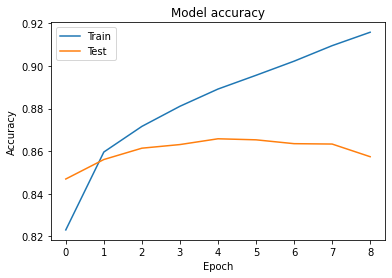

In [113]:
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

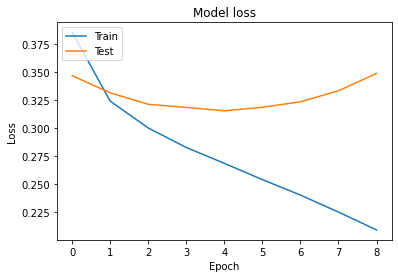

In [114]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [115]:
# loaded_model = load_model('best_model')
# print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

OSError: SavedModel file does not exist at: best_model/{saved_model.pbtxt|saved_model.pb}

In [121]:
## 기존의 LSTM 모델과의 성능 비교 ##

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

vocab_size = 40000
word_vector_dim = 300

model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_len, trainable=False)
model.add(e)
# model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [122]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [123]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1908/1916 [============================>.] - ETA: 0s - loss: 0.5966 - acc: 0.6639
Epoch 00001: val_acc improved from -inf to 0.72976, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets
1916/1916 [==============================] - 15s 8ms/step - loss: 0.5964 - acc: 0.6641 - val_loss: 0.5276 - val_acc: 0.7298
Epoch 2/15
1912/1916 [============================>.] - ETA: 0s - loss: 0.4983 - acc: 0.7469
Epoch 00002: val_acc improved from 0.72976 to 0.75881, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets
1916/1916 [==============================] - 12s 6ms/step - loss: 0.4982 - acc: 0.7470 - val_loss: 0.4857 - val_acc: 0.7588
Epoch 3/15
1913/1916 [============================>.] - ETA: 0s - loss: 0.4492 - acc: 0.7796
Epoch 00003: val_acc improved from 0.75881 to 0.77691, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets
1916/1916 [==============================] - 12s 6ms/step - loss: 0.449

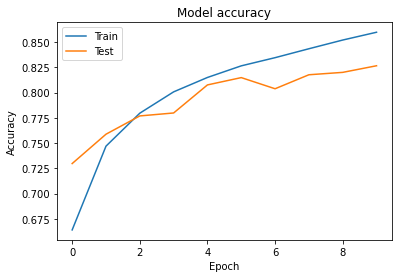

In [124]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

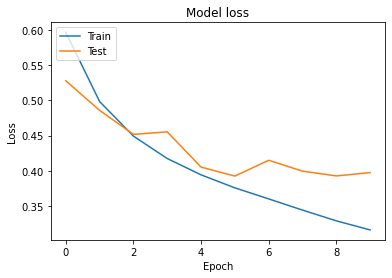

In [125]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [126]:
loaded_model = load_model('best_model')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1514/1514 [==============================] - 3s 2ms/step - loss: 0.4006 - acc: 0.8225

 테스트 정확도: 0.8225


# 회고

## * 이번 프로젝트에서 어려웠던 점.
    토큰화 하는 과정에서 Okt()를 활용할 때, 소요시간이 너무 길어서 그게 좀 기다리기 힘들었습니다. 이래서 LMS에서 Mecab()으로 진행했구나 싶었습니다.
    그 외에는 아직까지 모델을 생성하는 과정에서 하이퍼파라미터의 의미와 그 값들의 초기설정에 대한 고민이 많습니다. (학습모델에 대한 개념이 부족한듯 합니다.)
        
        
## * 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점.
    
    어렵지 않은 분야가 없겠지만, 특히나 자연어처리 부분은 전처리 과정부터 신경써야 할 부분이 많다고 느꼈습니다.
    단어 하나하나의 파악도 중요하지만 주변 단어와의 맥락도 신경써야하는 부분에서 개인적으로는 제일 어려운 영역같습니다.
    
    한국어에 대한 실습을 진행할 때, Mecab(일본어) vs. Okt(한국어)에서 Okt로 토큰화 했을 때, 더 성능이 좋을 것으로 에상했는데, 꼭 그렇지만도 않아서 좀 의아했습니다.
    그리고 네이버 영화 평가 텍스트 학습으로 생성된 word2vec vs. 기존에 제공되는 word2vec를 모델에 삽입해 학습을 시켰을 때, 당연히 후자의 정확도가 더 높을 것으로 예상되었는데 오히려 accuracy 면에서는 전자의 성능이 조금 더 좋은 것으로 나와서 신기했습니다. (뭐가 잘못된건가..?)
    
    
## * 루브릭 평가 지표를 맞추기 위해 시도한 것들.
    1) 다양한 방법으로 Text Classification task를 성공적으로 구현하였다. (3가지 이상의 모델이 성공적으로 시도되었는가?)
        네. 1D Convolution Neural Network(1D-CNN), LSTM, GRU 등의 학습 모델을 생성해서 학습이 잘 이루어지는지 확인하였습니다.
        
    2) gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다. (gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석하였는가?)
        네. gensim을 활용해서 네이버 영화리뷰 텍스트를 학습시킨 word2vec와 기존에 수많은 데이터로 이미 학습되어 있는 word2vec를 통해 각각의 성능을 확인해보았습니다.
        
    3) 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다. (네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성하였는가?)
        모델의 전반적은 accuracy는 85%정도가 나왔지만, 제공된 한국어 Word2Vec을 활용해 성능향상을 달성하지는 못했습니다.
        (오히려 한국어 Word2Vec을 활용해 모델을 학습한 경우 성능이 85%에서 82%로 소폭 하락한 것을 확인하였습니다.)
    
    